In [3]:
import urllib.request as scrape
from bs4 import BeautifulSoup
import pandas as pd
import time
import math
import os
import string
import logging
import numpy as np
import torch.tensor
import random
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
import numpy as np 
import pandas as pd 
import os
import urllib.request as scrape
import torch
import torch.nn as nn
Svenska_namn = pd.read_csv('../input/Svenska namn.csv') 

In [4]:

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


    response = scrape.urlopen(url)
    html_data = response.read()
    response.close()
    soup = BeautifulSoup(html_data)
    table = soup.find_all(attrs={'class': 'table_td'})
    names = []
    values = []
    for i in range(len(table)):
        hh = table[i].get_text()
        if i % 2 == 0:
            names.append(hh.strip())
        else:
            values.append(hh.strip())

    data = pd.DataFrame({'namn': names, 'antal': values})
    return data


def train_validate_test_split(df, train_percent=0.6, validate_percent=0.2, seed=666):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)

    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, test, validate


def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]


def letter2index(letter):
    return character_list.find(letter)


def indexesFromWord(word):
    return [letter2index(letter) for letter in word]


def tensorFromWord(word):
    indexes = indexesFromWord(word)
    return torch.tensor(indexes, dtype=torch.long).view(-1, 1)


def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i



def makeBatch_new(batch_size, maxchar, data = None, character_list = None):

    inds = random.sample(list(data.index), batch_size)
    seqs = list(data['namn'][inds])
    vectorized_seqs = [[character_list.index(tok) for tok in seq] for seq in seqs]
    seq_lengths = [len(x) for x in seqs]
    seq_tensor = Variable(torch.zeros((len(vectorized_seqs), maxchar))).long()

    for idx, (seq, seqlen) in enumerate(zip(vectorized_seqs, seq_lengths)):
        seq_tensor[idx, :seqlen] = torch.LongTensor(seq)

    sorting = sorted([(e, i) for i, e in enumerate(seq_lengths)], reverse=True)
    perm_idx = [x[1] for x in sorting]
    seq_lengths = [x[0] for x in sorting]
    seq_tensor = seq_tensor[perm_idx]
    seq_tensor = seq_tensor.permute(1,0)  

    labels = list(data['gender'][inds])
    label_tensor = torch.LongTensor(batch_size)

    for ii, gender in enumerate(labels):
        if gender == 'flicknamn':
            label_tensor[ii] = 1
        else:
            label_tensor[ii] = 0


    label_tensor = label_tensor[perm_idx]
    return seq_tensor, seq_lengths, label_tensor

In [5]:
class Params():
    def __init__(self):
        self.batch_size = 32
        self.hidden_size = 12
        self.embedding_size = 24
        self.epochs = 50
        self.nr_classes =2
        self.gpu = False
        self.learning_rate = 0.001
        self.train_ratio = 0.82
        self.val_ratio = 0.1
        self.test_ratio = 1-self.val_ratio-self.train_ratio
        self.n_layers = 2
        self.dropout = 0.3


Args = Params()

**Model**

In [6]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from torch.nn import functional as F

class LSTM_classifier(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_layers, dropout, embed_size):
        super().__init__()

        self.input_size = vocab_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.embed_size = embed_size
        self.embedding = nn.Embedding(self.input_size, self.embed_size)
        self.rnn = nn.LSTM(input_size=self.embed_size,
                           hidden_size=hidden_size,
                           dropout=dropout,
                           num_layers=n_layers, bidirectional=True)
        self.hidden2label = nn.Linear(2*hidden_size, 2)

        self.softmax = nn.LogSoftmax(dim=1)
        self.dropoutLayer = nn.Dropout()

    def init_hidden(self, batch_size):
        h0 = Variable(torch.zeros(self.n_layers*2, batch_size, self.hidden_size))
        c0 = Variable(torch.zeros(self.n_layers*2, batch_size, self.hidden_size))
        return h0, c0

    def forward(self, inputs, input_lengths): 
        self.hidden = self.init_hidden(inputs.size(-1))
        embedded = self.embedding(inputs)
        packed = pack_padded_sequence(embedded, input_lengths, batch_first=False)
        outputs, self.hidden = self.rnn(packed, self.hidden)
        output, output_lengths = pad_packed_sequence(outputs, batch_first=False)
        output = torch.transpose(output, 0, 1)
        output = torch.transpose(output, 1, 2)
        output = torch.tanh(output)
        output, indices = F.max_pool1d(output,output.size(2), return_indices=True)
        output = torch.tanh(output)
        output = output.squeeze(2)
        output = self.dropoutLayer(output)
        output = self.hidden2label(output)
        output = self.softmax(output)
        return output, self.hidden


In [7]:

letters = 'abcdefghijklmnopqrstxyz'
max_pages = 3
test_url = 'https://svenskanamn.alltforforaldrar.se/populart/flicknamn/h/page:2'
base_url = 'https://svenskanamn.alltforforaldrar.se/populart/'
genders = ['flicknamn', 'pojknamn']
pages = ['1', '2', '3']

if 'Svenska namn.csv' in os.listdir('../input'):
    Svenska_namn = pd.read_csv('../input/Svenska namn.csv')
else:
    Svenska_namn = pd.DataFrame()
    for i, letter in enumerate(letters):
        for j, gender in enumerate(genders):
            for k, page in enumerate(pages):
                url = base_url + gender + '/' + letter + '/page:' + page
                df = getTableFromSite(url)
                df['gender'] = gender
                Svenska_namn = Svenska_namn.append(df, ignore_index=True)
                print(url,'total_rows: ', Svenska_namn.shape[0],)
                time.sleep(1)

    Svenska_namn.to_csv('Svenska namn.csv')

Svenska_namn['namn'] = Svenska_namn['namn'].str.lower()
lista = list(Svenska_namn['namn'])
charlist = "åäöÅÄÖ -"
for ii in range(4140):
    charlist = charlist + lista[ii]

lista = ''.join(set(charlist))
lista = ''.join(sorted(lista))
character_list = sorted(set(charlist))
categories = ['pojknamn', 'flicknamn']
n_letters = len(character_list)
n_categories = len(categories)

train_data, val_data, test_data = train_validate_test_split(Svenska_namn,seed=333)

model = LSTM_classifier(vocab_size = n_letters, 
                        hidden_size = Args.hidden_size, 
                        n_layers = Args.n_layers, 
                        dropout = Args.dropout,
                        embed_size = Args.embedding_size)

optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

def train(input_tensor, input_sizes, target_tensor):
    model.hidden = model.init_hidden(Args.batch_size) 
    model.zero_grad()
    output, hidden = model.forward(input_tensor, input_sizes)
    loss = criterion(output, target_tensor)
    loss.backward()
    optimizer.step()
    return output, loss.item()

In [8]:
import time

current_loss = 0

all_losses = []
val_acc = []
train_acc = []
predictions = []
labels = []
print_every = int(len(train_data)/Args.batch_size) 
n_iters  = int(len(train_data)/Args.batch_size*Args.epochs)
plot_every = print_every
start = time.time()


for iter in range(n_iters):
    input_tensor, input_lengths, target_tensor = makeBatch_new(batch_size=Args.batch_size, 
                                                               maxchar= 14, 
                                                               data = train_data, 
                                                               character_list = character_list)
    output, loss = train(input_tensor=input_tensor, 
                         input_sizes=input_lengths, 
                         target_tensor=target_tensor)
    current_loss += loss
    predictions.extend(list(torch.argmax(output, dim=1).numpy()))
    labels.extend(list(target_tensor.numpy()))

    if (iter) % print_every == 0:
        corrects = 0
        corrects_train = 0
        input_tensor, input_lengths, target_tensor = makeBatch_new(batch_size=len(val_data), 
                                                                   maxchar= 14, 
                                                                   data =val_data, 
                                                                   character_list = character_list)
        
        output, hidden = model(inputs = input_tensor, input_lengths = input_lengths)
        preds = torch.argmax(output, dim=1)
        for i in range(len(preds)):
            if preds[i] == target_tensor[i]:
                corrects += 1
        
        for i in range(len(labels)):
            if labels[i] == predictions[i]:
                corrects_train +=1
        
        
        accuracy = corrects/len(preds)
        train_accuracy = corrects_train/len(labels)
        
        val_acc.append(accuracy)
        train_acc.append(train_accuracy)
        labels = []
        predictions =[]
        print('Val acc after {} epochs is: {} - train acc: {} - time elapsed: {} - avg train loss: {}'.format(int(iter/print_every+1), round(accuracy, 2),round(train_accuracy,2), timeSince(start), round(loss, 2)))

        
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0 

Val acc after 1 epochs is: 0.5 - train acc: 0.41 - time elapsed: 0m 0s - avg train loss: 0.73
Val acc after 2 epochs is: 0.55 - train acc: 0.5 - time elapsed: 0m 2s - avg train loss: 0.7
Val acc after 3 epochs is: 0.57 - train acc: 0.54 - time elapsed: 0m 4s - avg train loss: 0.68
Val acc after 4 epochs is: 0.61 - train acc: 0.6 - time elapsed: 0m 7s - avg train loss: 0.67
Val acc after 5 epochs is: 0.68 - train acc: 0.69 - time elapsed: 0m 10s - avg train loss: 0.66
Val acc after 6 epochs is: 0.7 - train acc: 0.76 - time elapsed: 0m 12s - avg train loss: 0.34
Val acc after 7 epochs is: 0.7 - train acc: 0.77 - time elapsed: 0m 14s - avg train loss: 0.58
Val acc after 8 epochs is: 0.72 - train acc: 0.75 - time elapsed: 0m 17s - avg train loss: 0.74
Val acc after 9 epochs is: 0.7 - train acc: 0.75 - time elapsed: 0m 19s - avg train loss: 0.43
Val acc after 10 epochs is: 0.71 - train acc: 0.77 - time elapsed: 0m 22s - avg train loss: 0.51
Val acc after 11 epochs is: 0.72 - train acc: 0.77

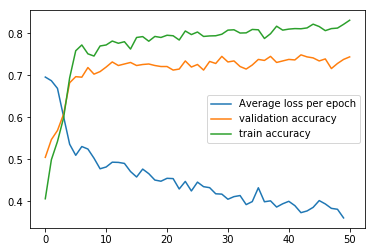

In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses[1:])
plt.plot(val_acc[:])
plt.plot(train_acc[:])
plt.legend(['Average loss per epoch','validation accuracy','train accuracy'])